<a href="https://colab.research.google.com/github/gshreya5/colab/blob/main/MasterCard_Stock_Price_Prediction_Using_LSTM_GRU_RNN_algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MasterCard Stock Price Prediction Using LSTM & GRU

We are going to use  MASTERCARD (MA) stock data via yfinance api's to train the LSTM and GRU models to forecast the stock price.

# Importing the libraries


In [195]:
!pip install yfinance --quiet

In [196]:
from pandas_datareader import data as pdr
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

# Loading Dataset

In [197]:
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo("MA", start="2006-05-01", end=None)

[*********************100%***********************]  1 of 1 completed


In [198]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-05-25,4.030,4.605,4.020,4.600,4.247397,395343000
2006-05-26,4.630,4.674,4.411,4.493,4.148599,103044000
2006-05-30,4.497,4.498,4.285,4.400,4.062729,49898000
2006-05-31,4.435,4.536,4.435,4.494,4.149523,30002000
2006-06-01,4.493,4.810,4.490,4.751,4.386822,62344000


# Data Analysis

Converting Date column to DateTime format 

In [199]:
data.index = pd.DatetimeIndex(data.index)

Dropping irrelevant columns

In [200]:
del data['Adj Close']

In [201]:
data.describe()

,Open,High,Low,Close,Volume
count,4210.000000,4210.000000,4210.000000,4210.000000,4.210000e+03
mean,126.137671,127.511181,124.727472,126.156848,1.162510e+07
std,120.874340,122.258260,119.439865,120.875793,1.704617e+07
min,4.030000,4.410000,4.020000,4.390000,6.411000e+05
25%,24.725000,25.034249,24.500000,24.740500,3.386650e+06
50%,81.068501,82.243500,79.886501,81.349998,5.420000e+06
75%,208.285000,210.277496,205.732494,208.334999,1.207325e+07
max,393.149994,401.500000,390.700012,396.750000,3.953430e+08


In [202]:
min  = round(data.describe().High.loc['min'],2)
max  = round(data.describe().High.loc['max'],2)
mean  = round(data.describe().High.loc['mean'],2)
std  = round(data.describe().High.loc['std'],2)

In [203]:
print(f'Analyzing High column : \nThe minimum stock price is ${min}, and the highest is ${max}. The mean is at ${mean} \nand the standard deviation ${std}, which means that stocks have high variance.')

Analyzing High column : 
The minimum stock price is $4.41, and the highest is $401.5. The mean is at $127.51 
and the standard deviation $122.26, which means that stocks have high variance.


Check for missing values

In [204]:
data.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# Data Visualization

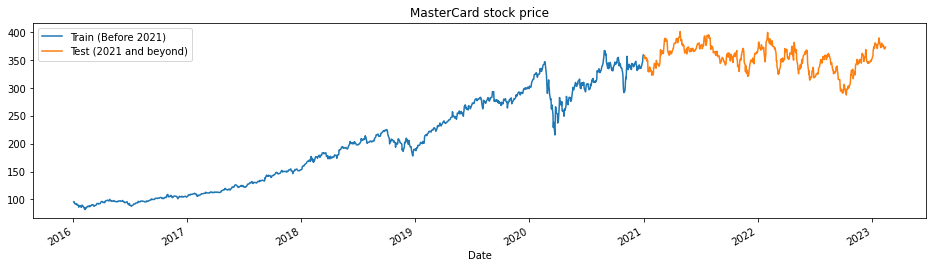

In [205]:
tstart = 2016
tend = 2020

def train_test_plot(data, tstart, tend):
    data.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    data.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(data,tstart,tend)

# Data Preprocessing


The train_test_split function divides the dataset into two subsets: training_set and test_set.

In [206]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(data, tstart, tend)

We will use the MinMaxScaler function to standardize our training set, which will help us avoid the outliers or anomalies.

In [207]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train, seq of length nsteps)  and outputs (y_train, o/p to those seq).
```
Ex : 123456 to
123 - 4
234 - 5
345 - 6
```



In [208]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [209]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

# LSTM Model


In [210]:
UNITS = 125

In [211]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=UNITS, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 125)               63500     
                                                                 
 dense_8 (Dense)             (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [212]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
38/38 [==============================] - 6s 75ms/step - loss: 0.0127
Epoch 2/50
38/38 [==============================] - 4s 94ms/step - loss: 0.0022
Epoch 3/50
38/38 [==============================] - 6s 164ms/step - loss: 0.0022
Epoch 4/50
38/38 [==============================] - 6s 150ms/step - loss: 0.0019
Epoch 5/50
38/38 [==============================] - 6s 169ms/step - loss: 0.0014
Epoch 6/50
38/38 [==============================] - 5s 143ms/step - loss: 0.0015
Epoch 7/50
38/38 [==============================] - 3s 72ms/step - loss: 9.2769e-04
Epoch 8/50
38/38 [==============================] - 3s 87ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 3s 88ms/step - loss: 9.8000e-04
Epoch 10/50
38/38 [==============================] - 3s 71ms/step - loss: 0.0010
Epoch 11/50
38/38 [==============================] - 3s 73ms/step - loss: 8.1010e-04
Epoch 12/50
38/38 [==============================] - 3s 76ms/step - loss: 8.4256e-04
Epoch 13/50
38/38

# Results

We are going to repeat preprocessing and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [213]:
data_total = data.loc[:,"High"]
inputs = data_total[len(data_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

17/17 [==============================] - 2s 59ms/step


The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.

The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [214]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction \n "+ str(return_rmse(test_set,predicted_stock_price)))
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    return "Root mean squared error : "+ str(round(rmse,2))

According to the line plot below, the single-layered LSTM model has performed well.



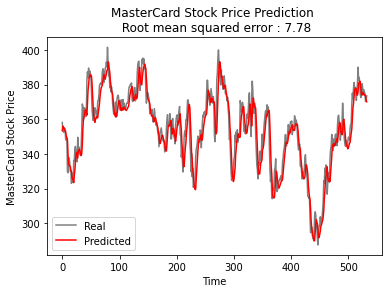

In [215]:
plot_predictions(test_set,predicted_stock_price)


In [216]:
print(f"The results look promising as for the model \n{return_rmse(test_set,predicted_stock_price)} on the test dataset.")

The results look promising as for the model 
Root mean squared error : 7.78 on the test dataset.


# GRU Model


We are going to keep everything the same and just replace the LSTM layer with the GRU layer to properly compare the results. The model structure contains a single GRU layer with 125 units and an output layer.

In [217]:
model_gru = Sequential()
model_gru.add(GRU(units=UNITS, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 125)               48000     
                                                                 
 dense_9 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [218]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
38/38 [==============================] - 5s 61ms/step - loss: 0.0122
Epoch 2/50
38/38 [==============================] - 4s 113ms/step - loss: 0.0014
Epoch 3/50
38/38 [==============================] - 5s 131ms/step - loss: 0.0012
Epoch 4/50
38/38 [==============================] - 4s 117ms/step - loss: 0.0012
Epoch 5/50
38/38 [==============================] - 4s 119ms/step - loss: 8.7467e-04
Epoch 6/50
38/38 [==============================] - 5s 134ms/step - loss: 0.0010
Epoch 7/50
38/38 [==============================] - 4s 96ms/step - loss: 6.8826e-04
Epoch 8/50
38/38 [==============================] - 2s 57ms/step - loss: 7.5846e-04
Epoch 9/50
38/38 [==============================] - 2s 56ms/step - loss: 6.9447e-04
Epoch 10/50
38/38 [==============================] - 3s 85ms/step - loss: 7.7613e-04
Epoch 11/50
38/38 [==============================] - 2s 59ms/step - loss: 6.5049e-04
Epoch 12/50
38/38 [==============================] - 2s 57ms/step - loss: 6.1964e-04
Epoc

# Results

As we can see, the real and predicted values are relatively close. The predicted line chart almost fits the actual values.

17/17 [==============================] - 1s 16ms/step


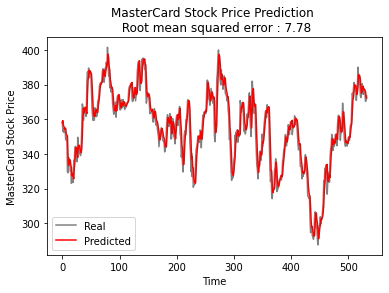

In [219]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [220]:
print(f"The results look promising as for the model \n{return_rmse(test_set,GRU_predicted_stock_price)} on the test dataset.")

The results look promising as for the model 
Root mean squared error : 6.83 on the test dataset.


In [221]:
print("GRU model performs better than the LSTM model.")

GRU model performs better than the LSTM model.
